In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from utils.data import get_train_dataloader, get_test_dataloader
from utils.model import VGG
from utils.optim import GD
from utils.ef21 import EF21
from utils.operators import top_k_op, hosvd_compression_op
from utils.criterions import compute_accuracy, compute_gradient_norm
from utils.train import save_training_data, load_training_data, save_model_and_optimizer, load_model_and_optimizer, find_last_checkpoint


def run_training(compression_op_name, compression_op, model_dir='./models', data_dir='./w'):
    device = 'mps'
    model = VGG().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = GD(model.parameters(), lr=0.1)
    ef_method = EF21(model.named_parameters())
    ef_method.compression_operator = compression_op

    trainloader = get_train_dataloader()

    start_epoch = 0
    checkpoint_path, start_epoch = find_last_checkpoint(
        model_dir, compression_op_name)
    if checkpoint_path:
        model, optimizer = load_model_and_optimizer(
            model, optimizer, ef_method, checkpoint_path)

    num_epochs = 2
    losses = []
    gradient_norms = []
    accuracies = []

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print(f"Starting epoch {epoch+1} with {compression_op_name}")
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()

            gradient_norms.append(compute_gradient_norm(model))
            losses.append(loss.item())

            ef_method.step()
            optimizer.step()

        accuracies.append(compute_accuracy(model, trainloader))

    save_model_and_optimizer(model, optimizer, ef_method, os.path.join(
        model_dir, f"{compression_op_name}_epoch_{epoch+1}.pt"))

    data = {
        'losses': losses,
        'gradient_norms': gradient_norms,
        'accuracies': accuracies
    }
    save_training_data(data, os.path.join(
        data_dir, f"{compression_op_name}_training_data.pt"))


# List of compression operators
compression_operators = {
    'TopK': top_k_op(k=5),
    'HOSVD': hosvd_compression_op(),
    # Add new operators here
}

# Run training and save data for each compression operator
for name, op in compression_operators.items():
    run_training(name, op)

Files already downloaded and verified
Starting epoch 5 with TopK
Starting epoch 6 with TopK
Files already downloaded and verified
Starting epoch 5 with HOSVD
Starting epoch 6 with HOSVD


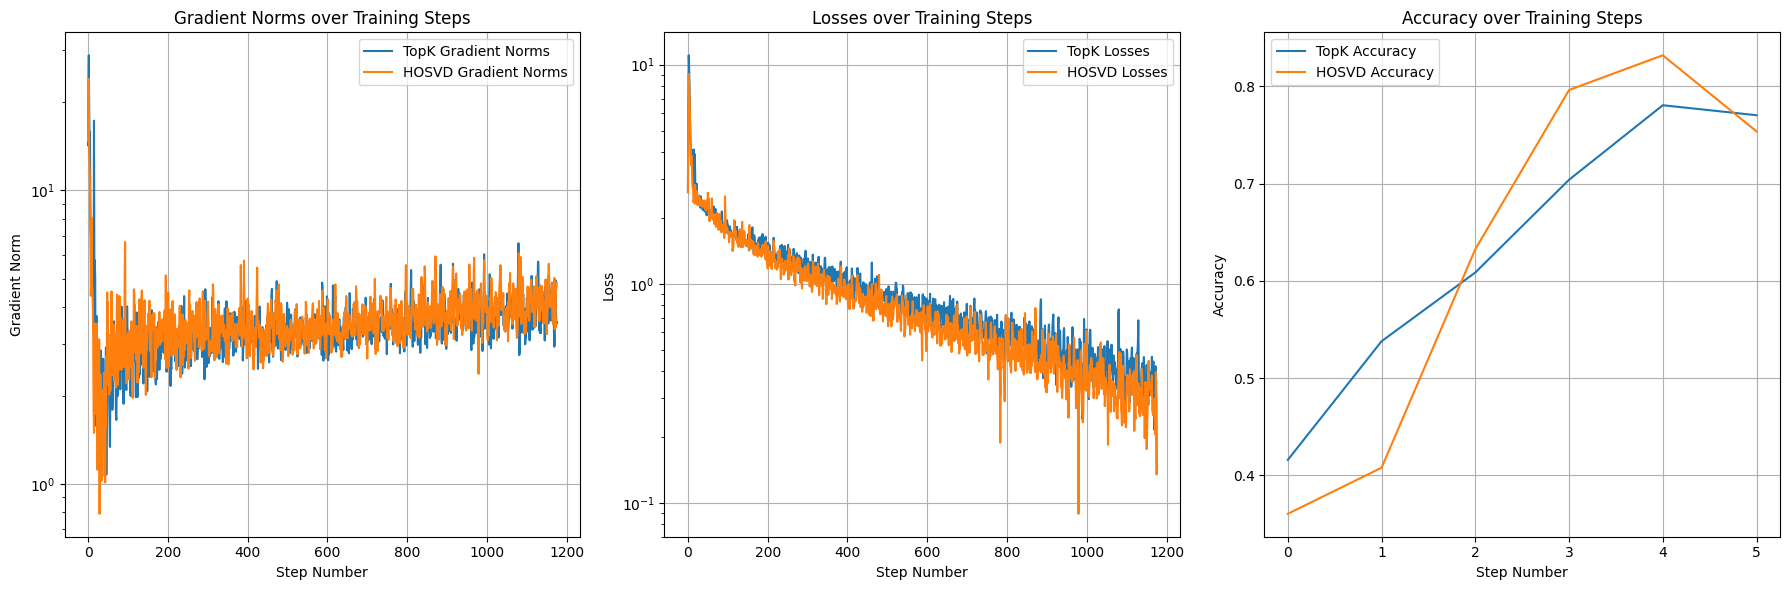

In [2]:
# Директория для данных
data_dir = "./w"

# Функция для загрузки и визуализации данных обучения
def plot_training_results():
    plt.figure(figsize=(18, 6))

    # Plot gradient norms
    plt.subplot(1, 3, 1)
    for op_name in compression_operators.keys():
        data = load_training_data(f"{data_dir}/{op_name}_training_data.pt")
        plt.semilogy(data['gradient_norms'], label=f'{op_name} Gradient Norms')
    plt.xlabel('Step Number')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norms over Training Steps')
    plt.legend()
    plt.grid(True)

    # Plot losses
    plt.subplot(1, 3, 2)
    for op_name in compression_operators.keys():
        data = load_training_data(f"{data_dir}/{op_name}_training_data.pt")
        plt.semilogy(data['losses'], label=f'{op_name} Losses')
    plt.xlabel('Step Number')
    plt.ylabel('Loss')
    plt.title('Losses over Training Steps')
    plt.legend()
    plt.grid(True)

    # Plot weights norms
    plt.subplot(1, 3, 3)
    for op_name in compression_operators.keys():
        data = load_training_data(f"{data_dir}/{op_name}_training_data.pt")
        plt.plot(data['accuracies'], label=f'{op_name} Accuracy')
    plt.xlabel('Step Number')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Training Steps')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_results()